In [1]:
import sys
import timeit
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

sys.path.append('../gmm_modules/')
from data_preparation import get_train_test_data, get_gen_data, get_train_data_for_NN
from metrics import metric_boxplot, eval_metrics, dump_metrics

np.random.seed(10)
%matplotlib inline

## Подготовим данные

In [2]:
%%time
path_to_dataset = '../../datasets/HIGGS.csv.gz'
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
train_size = 400000
test_size = 100000

X_train, X_test, y_train, y_test = get_train_test_data(path_to_dataset, column_names, train_size, test_size)

CPU times: user 3min 37s, sys: 54 s, total: 4min 30s
Wall time: 5min 21s


In [3]:
# split X_train by class
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]  

In [4]:
X_good.shape, X_bad.shape, X_train.shape, X_test.shape

((200000, 28), (200000, 28), (400000, 28), (100000, 28))

## Сгенерируем примеры используя GMM подход

In [5]:
import os
# import h5py
# import shutil
import numpy as np
import pandas as pd

from math import ceil
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
def get_XW(X_good, n_samples, n_components, sigma=0.01):
    # calculate GMM
    gm = GaussianMixture(n_components=n_components, n_init=4, covariance_type="full", verbose=0)
    gm.fit(X_good + np.random.normal(0, sigma, X_good.shape))
    print("BIC: ", gm.bic(X_good))

    # generate data
    X_gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                             size=ceil(gm.weights_[0] * n_samples)))
    for d in range(1, gm.n_components):
        X_gen=np.vstack((
            X_gen, 
            multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=ceil(gm.weights_[d]*n_samples))
        ))
    X_gen = np.random.permutation(X_gen)[:n_samples]

    # weights ~ 1/max_proba
    probas = np.empty((gm.n_components, X_gen.shape[0]))
    for d in range(gm.n_components):
        probas[d] = multivariate_normal.pdf(
            X_gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True
        )
    maxprob = np.max(probas, axis=0)
    w_gen = 1./(maxprob + 1e-2)
    return X_gen, w_gen

### n_components = 5

In [7]:
%%time
n_components = 5
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  11614739.1699206
CPU times: user 2min 41s, sys: 21.4 s, total: 3min 3s
Wall time: 3min 1s


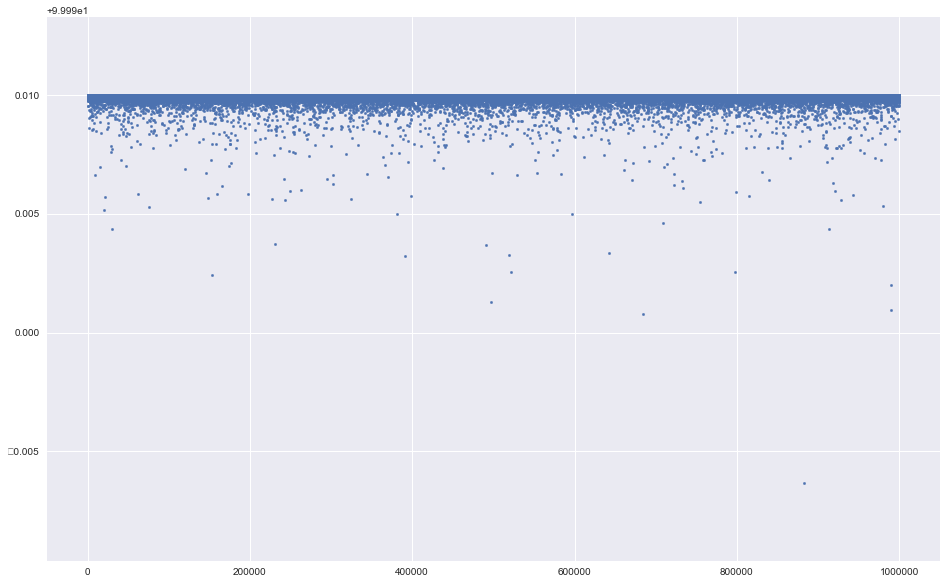

In [8]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

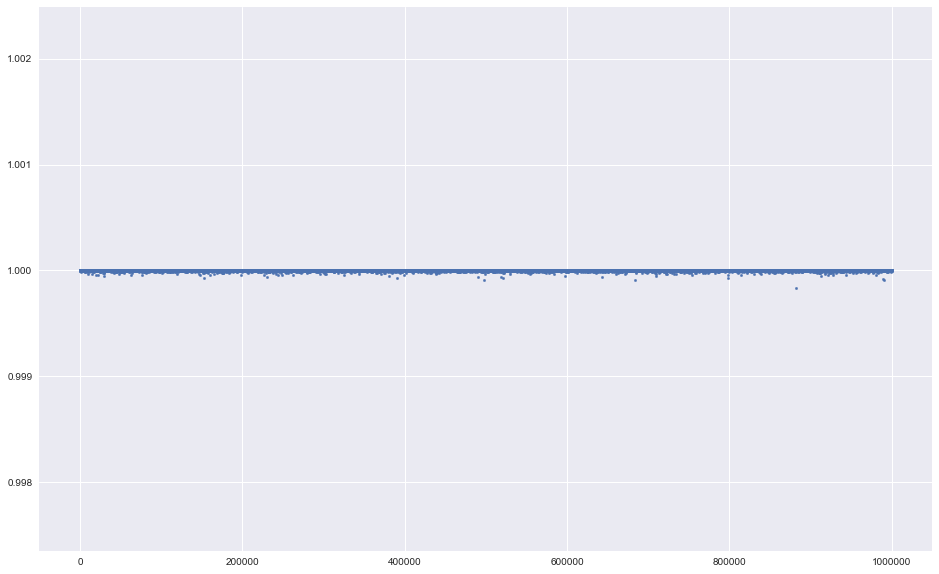

In [9]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [10]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(1.0, 0.0)

In [11]:
max(w_gen), min(w_gen)

(100.0, 99.98366995208669)

In [12]:
np.mean(w_gen), np.std(w_gen)

(99.99999381174732, 6.492254161953712e-05)

Проанализируем нормированные веса

In [13]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.909978, 0.090022)

In [14]:
max(w_gen_norm), min(w_gen_norm)

(1.0000000618825307, 0.9998367613932921)

In [15]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(0.9999999999999999, 6.492254563708944e-07)

### n_components = 15

In [16]:
%%time
n_components = 15
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  9537984.70268468
CPU times: user 7min 30s, sys: 1min 22s, total: 8min 53s
Wall time: 9min 5s


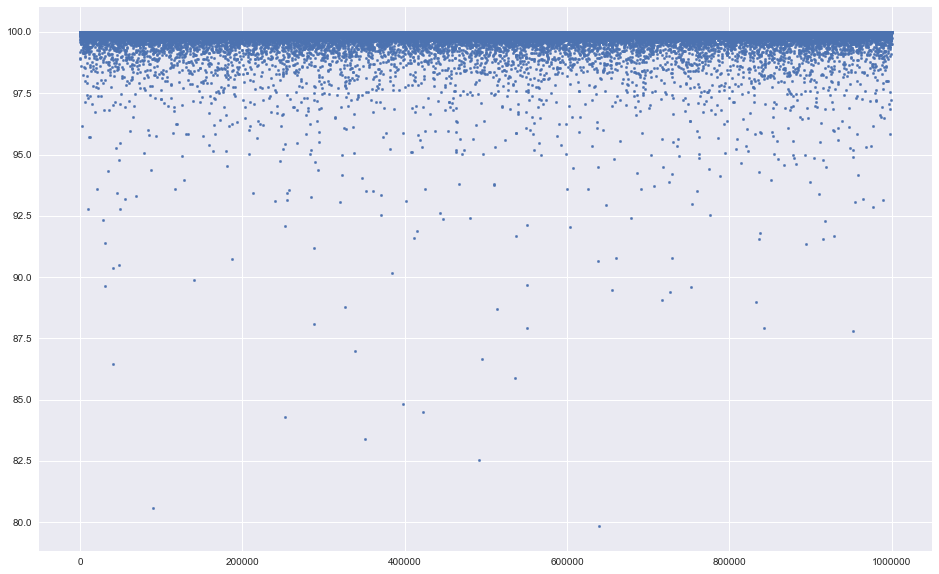

In [17]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

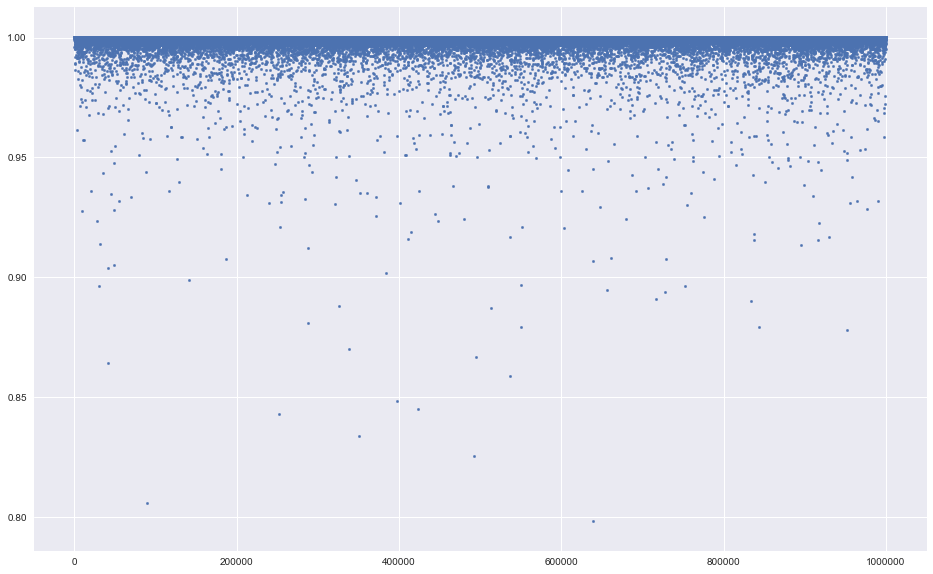

In [18]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [19]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(1.0, 0.0)

In [20]:
max(w_gen), min(w_gen)

(100.0, 79.84039090190785)

In [21]:
np.mean(w_gen), np.std(w_gen)

(99.98902740078499, 0.13735096290168342)

Проанализируем нормированные веса

In [22]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.933241, 0.066759)

In [23]:
max(w_gen_norm), min(w_gen_norm)

(1.0001097380332646, 0.7984915242938051)

In [24]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0, 0.0013736603552621926)

### n_components = 35

In [25]:
%%time
n_components = 35
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  8479837.79184041
CPU times: user 26min 9s, sys: 3min 46s, total: 29min 55s
Wall time: 31min 44s


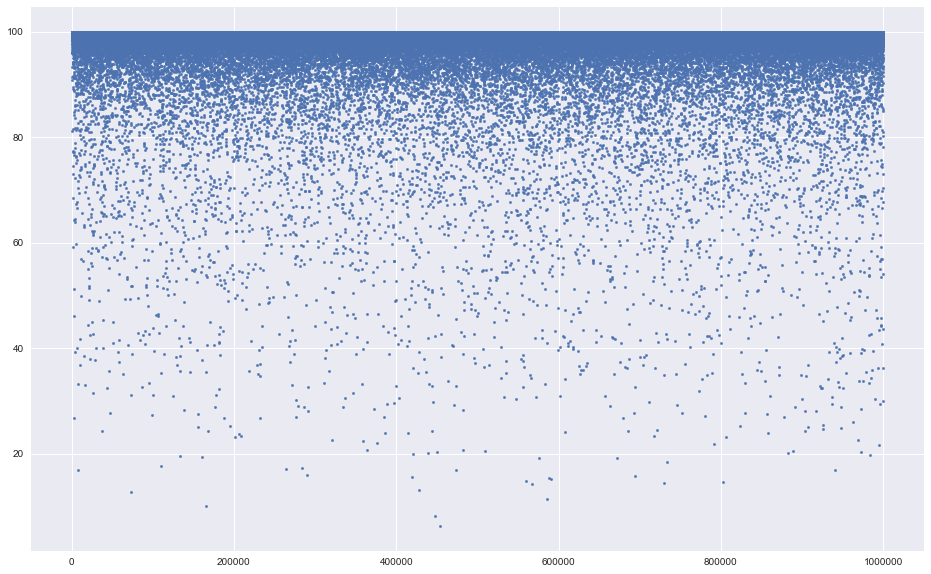

In [26]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

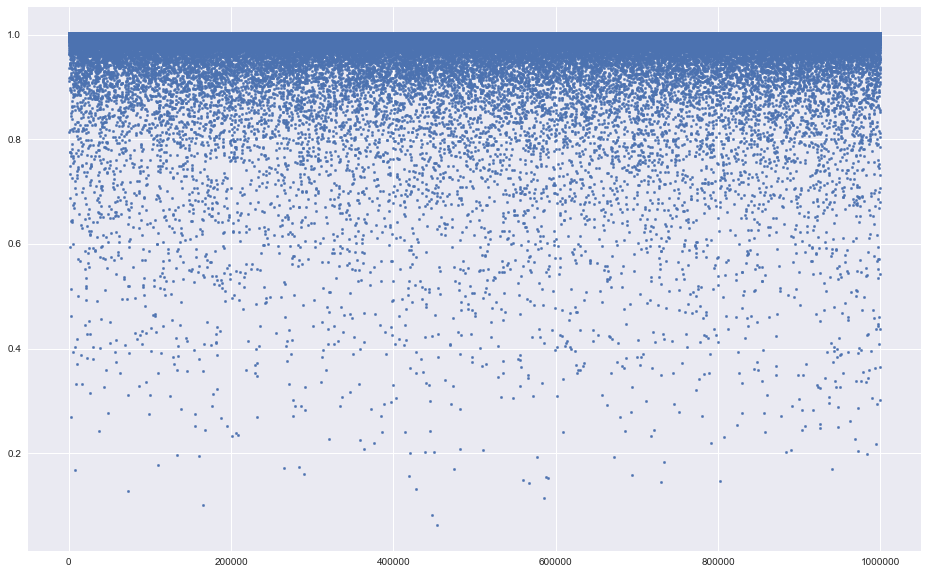

In [27]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [28]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.999498, 0.000502)

In [29]:
max(w_gen), min(w_gen)

(100.0, 6.253622958704149)

In [30]:
np.mean(w_gen), np.std(w_gen)

(99.68106258279549, 2.4481939410044546)

Проанализируем нормированные веса

In [31]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.923082, 0.076918)

In [32]:
max(w_gen_norm), min(w_gen_norm)

(1.0031995788261145, 0.06273631918309323)

In [33]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000004, 0.02456027130500315)

### n_components = 60

In [34]:
%%time
n_components = 60
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  7969681.752314762
CPU times: user 54min 54s, sys: 6min 59s, total: 1h 1min 54s
Wall time: 1h 7min 28s


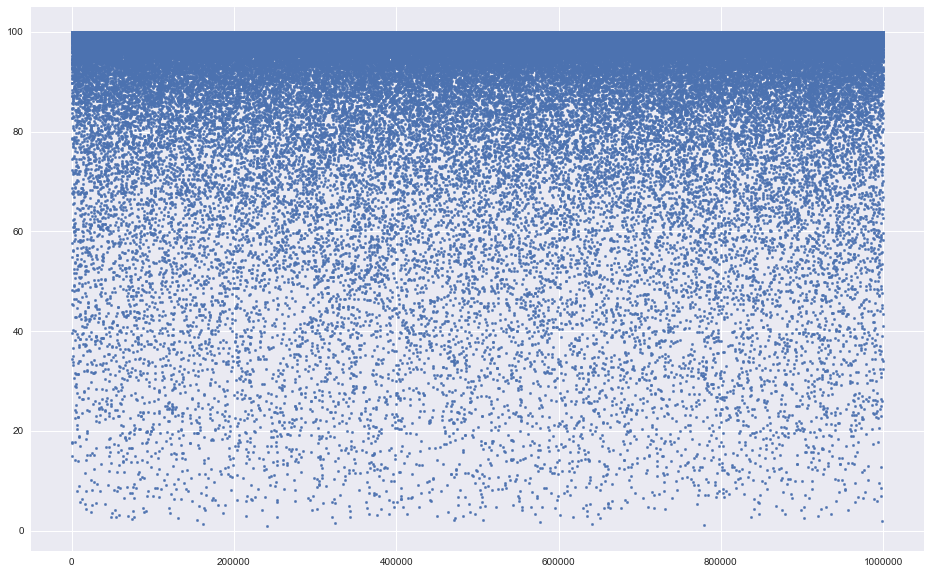

In [35]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

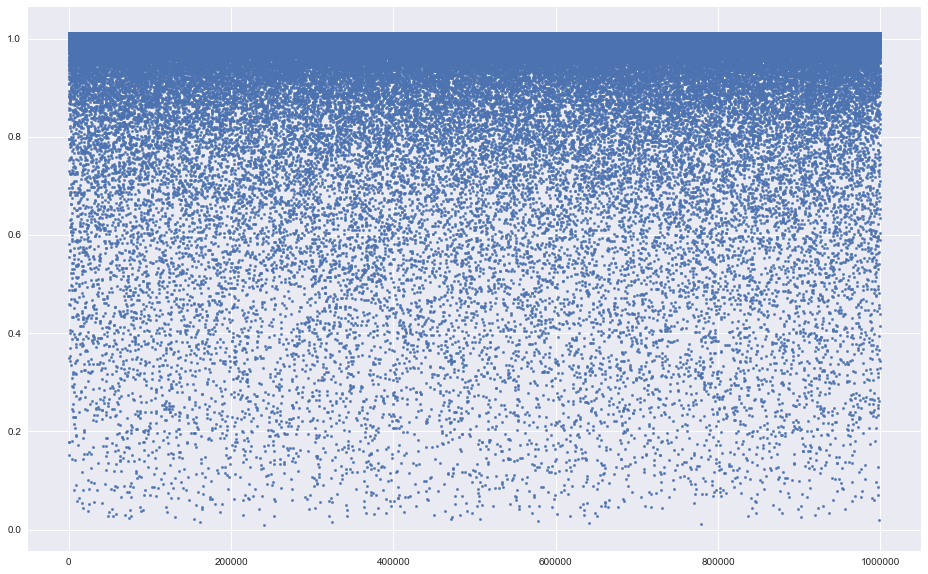

In [36]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [37]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.994923, 0.005077)

In [38]:
max(w_gen), min(w_gen)

(100.0, 0.9385245758617364)

In [39]:
np.mean(w_gen), np.std(w_gen)

(98.88369468223996, 6.22003498880332)

Проанализируем нормированные веса

In [40]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.915156, 0.084844)

In [41]:
max(w_gen_norm), min(w_gen_norm)

(1.0112890737077256, 0.009491196489751514)

In [42]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.000000000000001, 0.06290253422256553)

### n_components = 100

In [43]:
%%time
n_components = 100
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  7537000.3778485805
CPU times: user 1h 53min 1s, sys: 17min 46s, total: 2h 10min 47s
Wall time: 2h 25min 21s


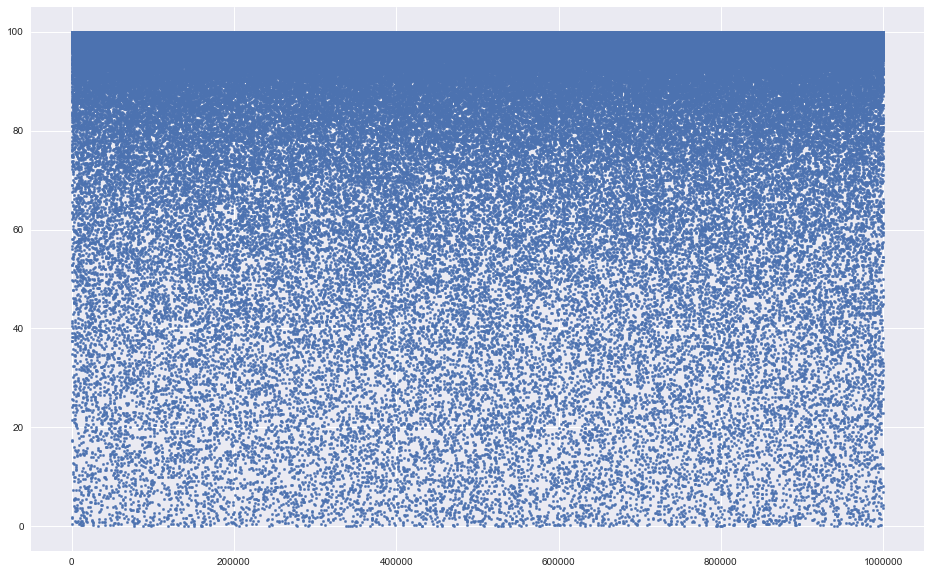

In [44]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

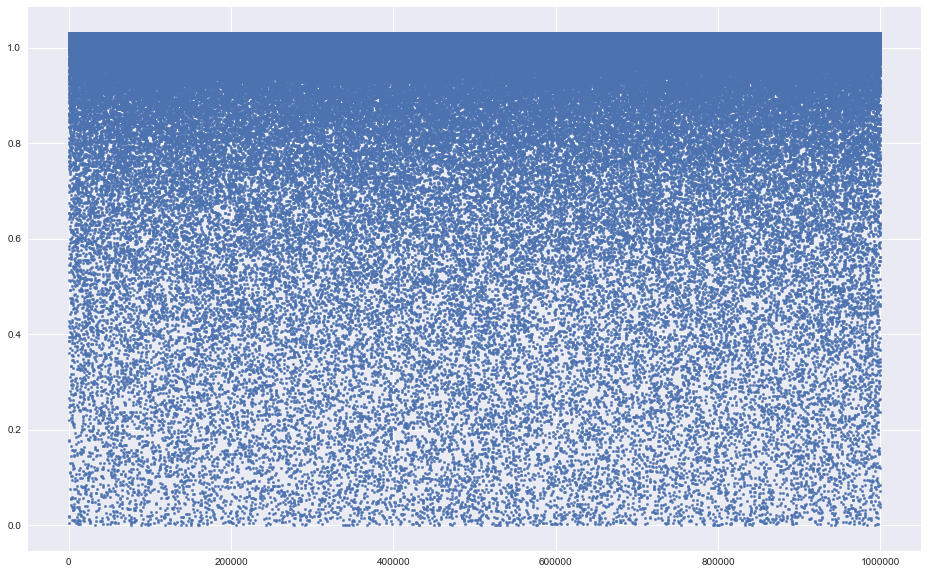

In [45]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [46]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.981192, 0.018808)

In [47]:
max(w_gen), min(w_gen)

(100.0, 0.01892050152492554)

In [48]:
np.mean(w_gen), np.std(w_gen)

(96.98482101474245, 11.414870020010875)

Проанализируем нормированные веса

In [49]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.87962, 0.12038)

In [50]:
max(w_gen_norm), min(w_gen_norm)

(1.031089184407519, 0.00019508724485916694)

In [51]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0, 0.11769749019050856)

In [52]:
path_to_gen_file = './gen_data/gen_100.npz'
np.savez(path_to_gen_file, X_gen=X_gen, w_gen=w_gen_norm)

### n_components = 200

In [53]:
%%time
n_components = 200
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

BIC:  7568842.778216305
CPU times: user 4h 3min 51s, sys: 36min 47s, total: 4h 40min 38s
Wall time: 5h 26min 46s


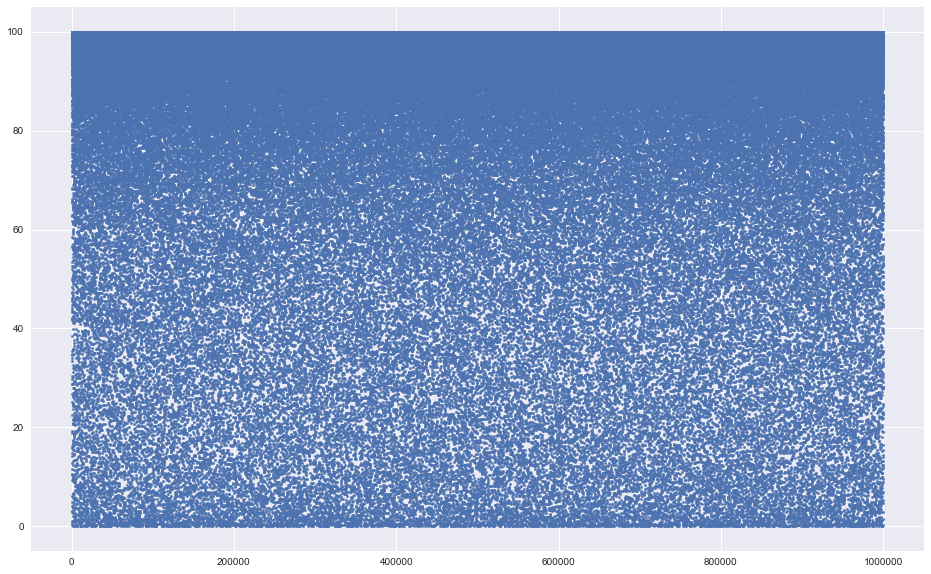

In [54]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

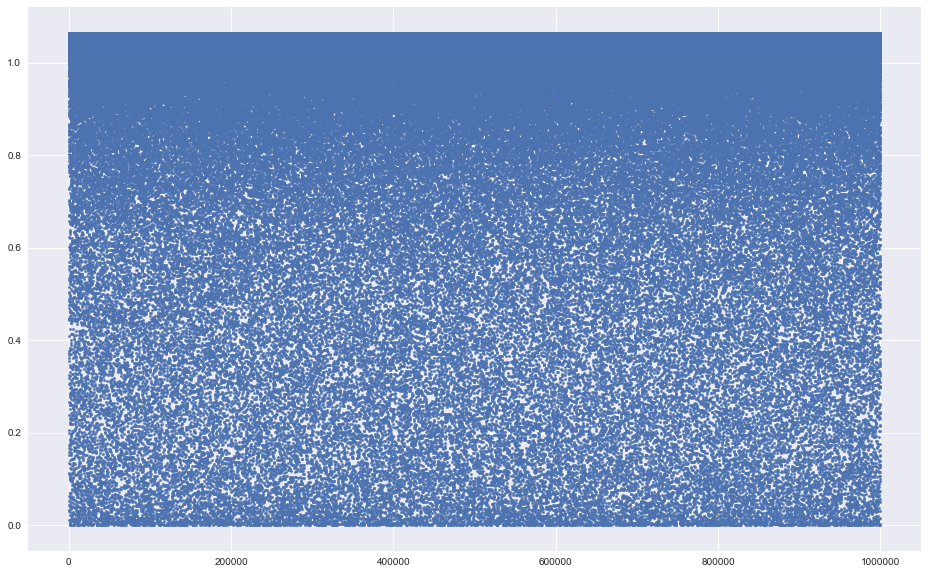

In [55]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [56]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.954304, 0.045696)

In [57]:
max(w_gen), min(w_gen)

(100.0, 0.00034957124135509386)

In [58]:
np.mean(w_gen), np.std(w_gen)

(93.9831460500274, 17.345133083726775)

Проанализируем нормированные веса

In [59]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.847046, 0.152954)

In [60]:
max(w_gen_norm), min(w_gen_norm)

(1.0640205632908886, 3.719509891369421e-06)

In [61]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000002, 0.18455578274102388)

In [62]:
path_to_gen_file = './gen_data/gen_200.npz'
np.savez(path_to_gen_file, X_gen=X_gen, w_gen=w_gen_norm)

### n_components = 500

In [63]:
%%time
n_components = 500
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_XW(X_good, n_samples, n_components, sigma=0.01)

# normalize
w_gen_norm = w_gen * n_samples/np.sum(w_gen)

/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 4 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BIC:  8575665.547957856
CPU times: user 11h 8min 53s, sys: 1h 42min 34s, total: 12h 51min 28s
Wall time: 14h 26min 29s


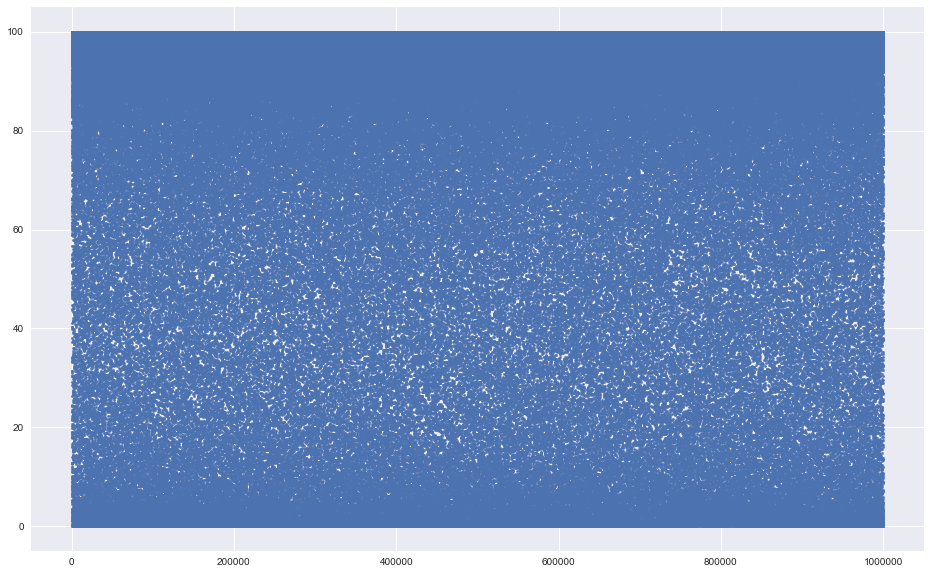

In [64]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
# plt.ylim(0, 15)
plt.show()

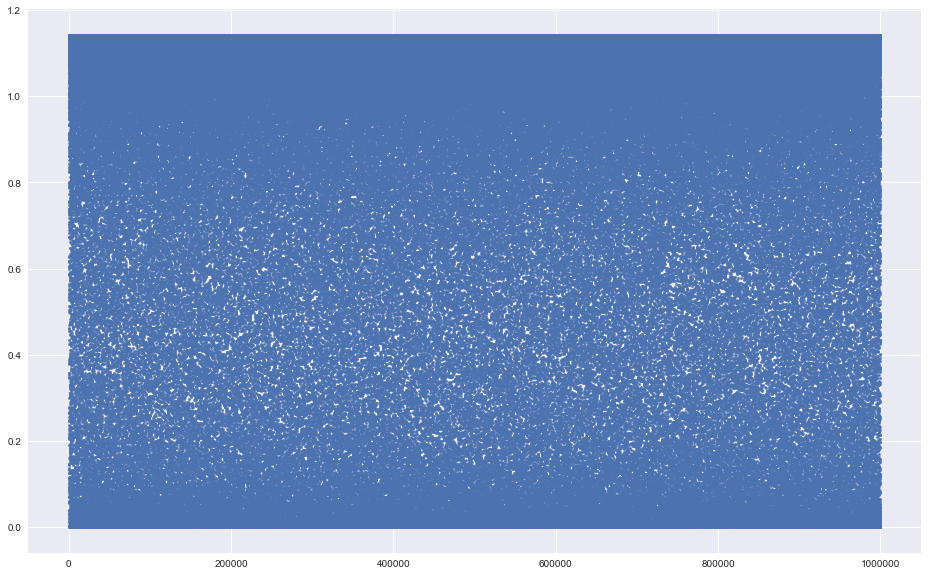

In [65]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen_norm)), w_gen_norm, s=6)
# plt.ylim(0, 15)
plt.show()

Проанализируем веса

In [66]:
len(w_gen[w_gen>50])/len(w_gen), len(w_gen[w_gen<50])/len(w_gen)

(0.888937, 0.111063)

In [67]:
max(w_gen), min(w_gen)

(100.0, 1.468176859042907e-10)

In [68]:
np.mean(w_gen), np.std(w_gen)

(87.52128489281809, 26.293267843328728)

Проанализируем нормированные веса

In [69]:
len(w_gen_norm[w_gen_norm>1])/len(w_gen_norm), len(w_gen_norm[w_gen_norm<1])/len(w_gen_norm)

(0.793554, 0.206446)

In [70]:
max(w_gen_norm), min(w_gen_norm)

(1.1425792037041482, 1.677508346502102e-12)

In [71]:
np.mean(w_gen_norm), np.std(w_gen_norm)

(1.0000000000000007, 0.30042141035210435)

In [72]:
path_to_gen_file = './gen_data/gen_500.npz'
np.savez(path_to_gen_file, X_gen=X_gen, w_gen=w_gen_norm)

### График BIC

я не сообразил сразу сохранять значение bic, поэтому вручную

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
components = [5, 15, 35, 60, 100, 200, 500]
bics_susy = [1756987.4549180653, 671233.2123981108, -151447.20195683851, -672929.9494915995, -1156253.975190586,
             -1673064.810853648, -1996025.6841273129]
bics_higgs = [11614739.1699206, 9537984.70268468, 8479837.79184041, 7969681.752314762, 7537000.3778485805,
             7568842.778216305, 8575665.547957856]

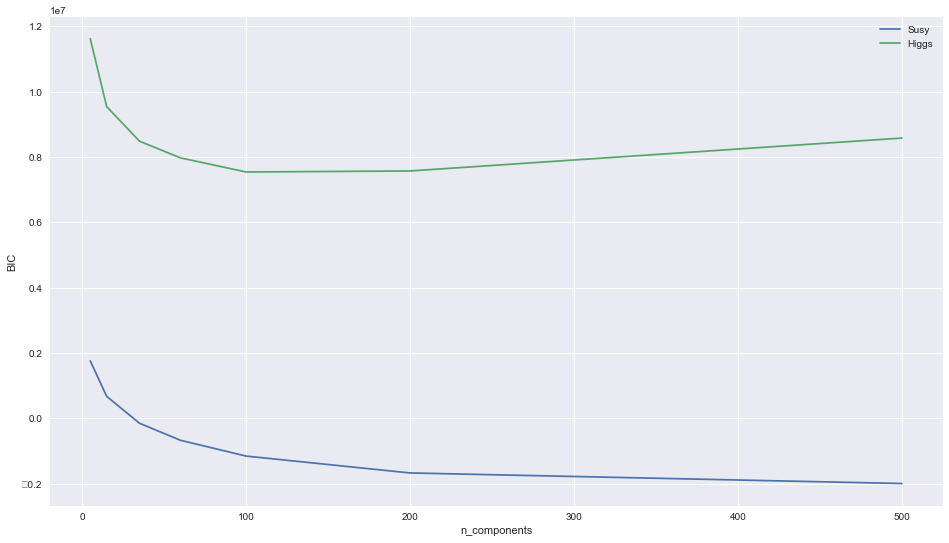

In [77]:
plt.figure(figsize=(16, 9))
plt.plot(components, bics_susy, label='Susy')
plt.plot(components, bics_higgs, label='Higgs')
plt.xlabel('n_components')
plt.ylabel('BIC')
plt.legend()
plt.show()